# 🔬 피부 질환 감지 - MobileNet (PyTorch)

## 프로젝트 개요
- **목적**: 피부암 및 피부 질환을 모바일 환경에서 감지할 수 있는 경량 딥러닝 모델 개발
- **데이터셋**: HAM10000 (Human Against Machine with 10000 training images)
- **모델**: MobileNetV2 (PyTorch 버전)
- **프레임워크**: PyTorch + torchvision
- **클래스**: 7가지 피부 질환
  - akiec: Actinic keratoses (광선각화증)
  - bcc: Basal cell carcinoma (기저세포암)
  - bkl: Benign keratosis-like lesions (양성 각화증)
  - df: Dermatofibroma (피부섬유종)
  - mel: Melanoma (흑색종)
  - nv: Melanocytic nevi (멜라닌 세포 모반)
  - vasc: Vascular lesions (혈관 병변)

## 1. 필요한 라이브러리 설치 및 임포트

In [ ]:
# 필요한 패키지 설치 (처음 실행 시)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install pandas numpy matplotlib seaborn scikit-learn pillow tqdm

Looking in indexes: https://download.pytorch.org/whl/cu121


In [19]:
# 라이브러리 임포트
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
from tqdm import tqdm

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 버전 확인
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU 이름: {torch.cuda.get_device_name(0)}")
    print(f"GPU 개수: {torch.cuda.device_count()}")
else:
    print("CPU 모드로 실행됩니다.")

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n사용 디바이스: {device}")

# 재현성을 위한 시드 설정
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

PyTorch 버전: 2.7.1+cu118
CUDA 사용 가능: True
GPU 이름: NVIDIA GeForce RTX 3060
GPU 개수: 1

사용 디바이스: cuda


## 2. 데이터 경로 설정 및 메타데이터 로드

In [20]:
# 데이터 경로 설정
BASE_DIR = r'C:\Users\shrjs\Desktop\Skin_Disease_Detection'
IMAGE_DIR = os.path.join(BASE_DIR, 'processed_images_dataset', 'processed_images')
METADATA_PATH = os.path.join(BASE_DIR, 'HAM10000_metadata.csv')

# 메타데이터 로드
df = pd.read_csv(METADATA_PATH)

print(f"전체 데이터 수: {len(df)}")
print(f"\n데이터셋 정보:")
print(df.info())
print(f"\n처음 5개 데이터:")
df.head()

전체 데이터 수: 10015

데이터셋 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None

처음 5개 데이터:


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## 3. 데이터 탐색 및 시각화

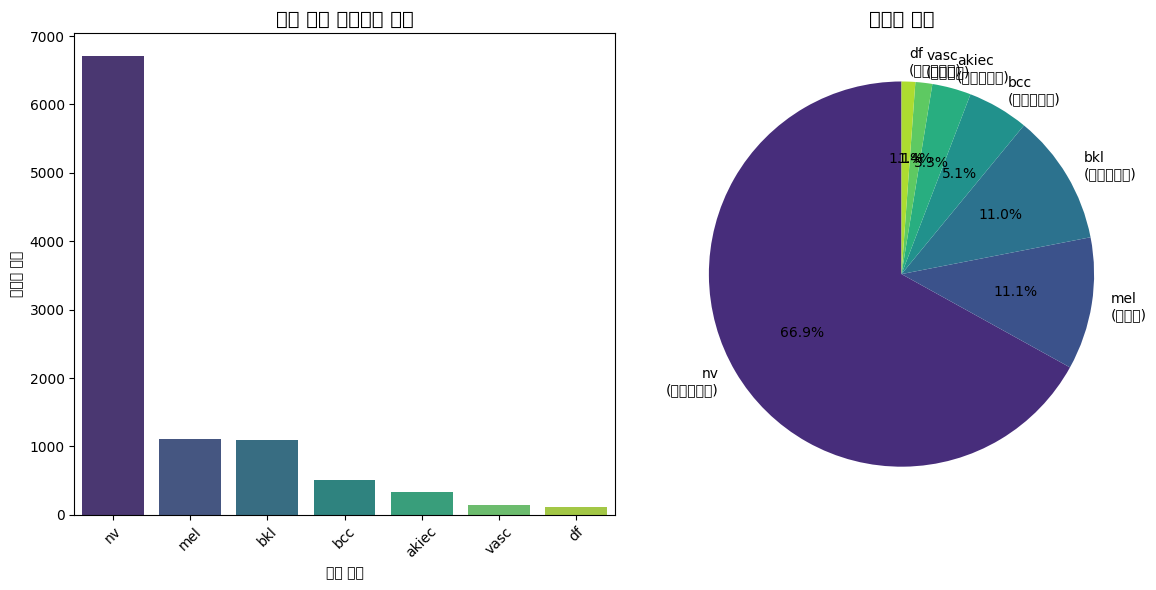


클래스별 상세 정보:
nv (멜라닌모반): 6705개 (66.95%)
mel (흑색종): 1113개 (11.11%)
bkl (양성각화증): 1099개 (10.97%)
bcc (기저세포암): 514개 (5.13%)
akiec (광선각화증): 327개 (3.27%)
vasc (혈관병변): 142개 (1.42%)
df (피부섬유종): 115개 (1.15%)


In [21]:
# 클래스 분포 확인
plt.figure(figsize=(12, 6))

# 클래스별 개수
plt.subplot(1, 2, 1)
class_counts = df['dx'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('피부 질환 클래스별 분포', fontsize=14, fontweight='bold')
plt.xlabel('질환 유형')
plt.ylabel('이미지 개수')
plt.xticks(rotation=45)

# 클래스 설명
class_names = {
    'akiec': '광선각화증',
    'bcc': '기저세포암',
    'bkl': '양성각화증',
    'df': '피부섬유종',
    'mel': '흑색종',
    'nv': '멜라닌모반',
    'vasc': '혈관병변'
}

# 비율
plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=[f"{k}\n({class_names[k]})" for k in class_counts.index], 
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(class_counts)))
plt.title('클래스 비율', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n클래스별 상세 정보:")
for dx, count in class_counts.items():
    print(f"{dx} ({class_names[dx]}): {count}개 ({count/len(df)*100:.2f}%)")

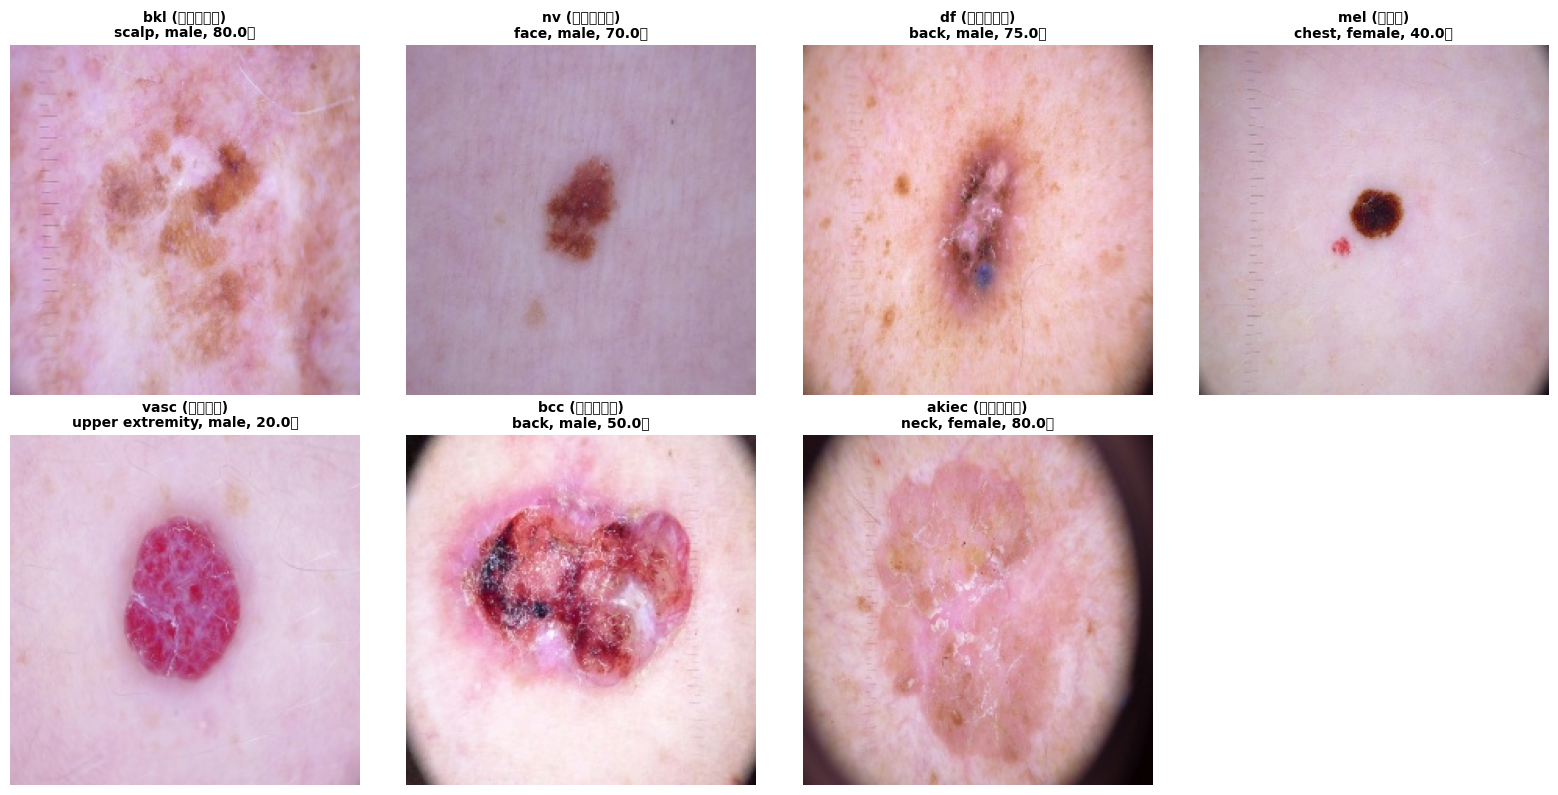

In [22]:
# 각 클래스별 샘플 이미지 시각화
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, dx_type in enumerate(df['dx'].unique()):
    sample = df[df['dx'] == dx_type].iloc[0]
    img_path = os.path.join(IMAGE_DIR, sample['image_id'] + '.jpg')
    
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"{dx_type} ({class_names[dx_type]})\n{sample['localization']}, {sample['sex']}, {sample['age']}세", 
                           fontsize=10, fontweight='bold')
        axes[idx].axis('off')

# 마지막 빈 subplot 제거
if len(df['dx'].unique()) < 8:
    fig.delaxes(axes[7])

plt.tight_layout()
plt.show()

## 4. 데이터 전처리

In [23]:
# 이미지 경로 추가
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(IMAGE_DIR, x + '.jpg'))

# 존재하는 이미지만 필터링
df['exists'] = df['image_path'].apply(os.path.exists)
df_filtered = df[df['exists']].copy()

print(f"전체 메타데이터: {len(df)}개")
print(f"실제 존재하는 이미지: {len(df_filtered)}개")
print(f"누락된 이미지: {len(df) - len(df_filtered)}개")

# 필요한 컬럼만 선택
df_filtered = df_filtered[['image_id', 'image_path', 'dx']].copy()

# 클래스를 숫자로 인코딩
class_to_idx = {cls: idx for idx, cls in enumerate(sorted(df_filtered['dx'].unique()))}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

df_filtered['label'] = df_filtered['dx'].map(class_to_idx)

print("\n클래스 인코딩:")
for cls, idx in class_to_idx.items():
    print(f"{idx}: {cls} ({class_names[cls]})")

df_filtered.head()

전체 메타데이터: 10015개
실제 존재하는 이미지: 10015개
누락된 이미지: 0개

클래스 인코딩:
0: akiec (광선각화증)
1: bcc (기저세포암)
2: bkl (양성각화증)
3: df (피부섬유종)
4: mel (흑색종)
5: nv (멜라닌모반)
6: vasc (혈관병변)


,image_id,image_path,dx,label
0,ISIC_0027419,C:\Users\shrjs\Desktop\Skin_Disease_Detection\...,bkl,2
1,ISIC_0025030,C:\Users\shrjs\Desktop\Skin_Disease_Detection\...,bkl,2
2,ISIC_0026769,C:\Users\shrjs\Desktop\Skin_Disease_Detection\...,bkl,2
3,ISIC_0025661,C:\Users\shrjs\Desktop\Skin_Disease_Detection\...,bkl,2
4,ISIC_0031633,C:\Users\shrjs\Desktop\Skin_Disease_Detection\...,bkl,2


In [24]:
# 학습/검증/테스트 데이터 분할 (70% / 15% / 15%)
train_df, temp_df = train_test_split(df_filtered, test_size=0.3, stratify=df_filtered['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"학습 데이터: {len(train_df)}개 ({len(train_df)/len(df_filtered)*100:.1f}%)")
print(f"검증 데이터: {len(val_df)}개 ({len(val_df)/len(df_filtered)*100:.1f}%)")
print(f"테스트 데이터: {len(test_df)}개 ({len(test_df)/len(df_filtered)*100:.1f}%)")

# 클래스 불균형 처리를 위한 가중치 계산
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weight_tensor = torch.FloatTensor(class_weights).to(device)

print("\n클래스 가중치:")
for idx, weight in enumerate(class_weights):
    print(f"{idx_to_class[idx]}: {weight:.2f}")

학습 데이터: 7010개 (70.0%)
검증 데이터: 1502개 (15.0%)
테스트 데이터: 1503개 (15.0%)

클래스 가중치:
akiec: 4.37
bcc: 2.78
bkl: 1.30
df: 12.36
mel: 1.29
nv: 0.21
vasc: 10.12


## 5. PyTorch Dataset 및 DataLoader 설정

In [10]:
# 커스텀 Dataset 클래스
class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.loc[idx, 'label']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("SkinLesionDataset 클래스 정의 완료")

SkinLesionDataset 클래스 정의 완료


In [11]:
# 이미지 파라미터 설정
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = len(class_to_idx)

# 데이터 증강 (학습 데이터용)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 검증/테스트 데이터용 (증강 없이 정규화만)
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset 생성
train_dataset = SkinLesionDataset(train_df, transform=train_transform)
val_dataset = SkinLesionDataset(val_df, transform=val_test_transform)
test_dataset = SkinLesionDataset(test_df, transform=val_test_transform)

# DataLoader 생성 (Windows 호환)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

print(f"학습 배치 수: {len(train_loader)}")
print(f"검증 배치 수: {len(val_loader)}")
print(f"테스트 배치 수: {len(test_loader)}")

# 샘플 배치 확인
sample_images, sample_labels = next(iter(train_loader))
print(f"\n배치 이미지 shape: {sample_images.shape}")
print(f"배치 레이블 shape: {sample_labels.shape}")

학습 배치 수: 220
검증 배치 수: 47
테스트 배치 수: 47

배치 이미지 shape: torch.Size([32, 3, 224, 224])
배치 레이블 shape: torch.Size([32])


## 6. MobileNetV2 모델 구축

In [10]:
# MobileNetV2 모델 로드 (ImageNet 사전 학습 가중치)
model = models.mobilenet_v2(pretrained=True)

# 분류기 레이어 교체
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.3),
    nn.Linear(256, NUM_CLASSES)
)

# 모델을 디바이스로 이동
model = model.to(device)

print("MobileNetV2 모델 구축 완료")
print(f"총 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")
print(f"학습 가능한 파라미터 수: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\shrjs/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 93.6MB/s]


MobileNetV2 모델 구축 완료
총 파라미터 수: 2,554,119
학습 가능한 파라미터 수: 2,554,119


In [12]:
# 손실 함수 (클래스 가중치 적용)
criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)

# 옵티마이저
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러 (verbose 제거)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print("손실 함수 및 옵티마이저 설정 완료")

손실 함수 및 옵티마이저 설정 완료


## 7. 학습 및 검증 함수

In [13]:
# 학습 함수
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': running_loss/len(loader), 'acc': 100.*correct/total})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# 검증 함수
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': running_loss/len(loader), 'acc': 100.*correct/total})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

print("학습 및 검증 함수 정의 완료")

학습 및 검증 함수 정의 완료


## 8. 모델 학습 (1단계: 전이 학습)

In [14]:
# 모델 저장 디렉토리
MODEL_DIR = os.path.join(BASE_DIR, 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

# 1단계: 특징 추출기 동결
for param in model.features.parameters():
    param.requires_grad = False

EPOCHS_STAGE1 = 100
best_val_acc = 0.0
history_stage1 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("=" * 60)
print("1단계 학습 시작 (전이 학습 - 특징 추출기 동결)")
print("=" * 60)

for epoch in range(EPOCHS_STAGE1):
    print(f"\nEpoch {epoch+1}/{EPOCHS_STAGE1}")
    print("-" * 60)
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    history_stage1['train_loss'].append(train_loss)
    history_stage1['train_acc'].append(train_acc)
    history_stage1['val_loss'].append(val_loss)
    history_stage1['val_acc'].append(val_acc)
    
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # 학습률 조정
    scheduler.step(val_loss)
    
    # 최고 성능 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'mobilenet_skin_disease_best_stage1.pth'))
        print(f"✅ 최고 성능 모델 저장! (Val Acc: {val_acc:.2f}%)")

print("\n1단계 학습 완료!")

1단계 학습 시작 (전이 학습 - 특징 추출기 동결)

Epoch 1/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.56it/s, loss=1.29, acc=56.8] 



Train Loss: 1.6033 | Train Acc: 37.62%
Val Loss: 1.2915 | Val Acc: 56.79%
✅ 최고 성능 모델 저장! (Val Acc: 56.79%)

Epoch 2/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.43it/s, loss=1.15, acc=57.9] 



Train Loss: 1.4344 | Train Acc: 50.64%
Val Loss: 1.1549 | Val Acc: 57.86%
✅ 최고 성능 모델 저장! (Val Acc: 57.86%)

Epoch 3/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.29it/s, loss=1.13, acc=57.6] 



Train Loss: 1.3404 | Train Acc: 54.54%
Val Loss: 1.1269 | Val Acc: 57.59%

Epoch 4/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.59it/s, loss=1.1, acc=56.3]  



Train Loss: 1.3527 | Train Acc: 54.72%
Val Loss: 1.0987 | Val Acc: 56.26%

Epoch 5/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.39it/s, loss=1.07, acc=56.6] 



Train Loss: 1.3155 | Train Acc: 53.94%
Val Loss: 1.0680 | Val Acc: 56.59%

Epoch 6/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.33it/s, loss=1.05, acc=65]   



Train Loss: 1.3339 | Train Acc: 53.64%
Val Loss: 1.0527 | Val Acc: 65.05%
✅ 최고 성능 모델 저장! (Val Acc: 65.05%)

Epoch 7/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.44it/s, loss=1.05, acc=61.2] 



Train Loss: 1.2889 | Train Acc: 55.19%
Val Loss: 1.0531 | Val Acc: 61.19%

Epoch 8/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.48it/s, loss=1.08, acc=61.9] 



Train Loss: 1.2896 | Train Acc: 54.39%
Val Loss: 1.0761 | Val Acc: 61.85%

Epoch 9/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.21it/s, loss=1.03, acc=59.7] 



Train Loss: 1.3195 | Train Acc: 54.85%
Val Loss: 1.0335 | Val Acc: 59.72%

Epoch 10/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.59it/s, loss=1.01, acc=62.5] 



Train Loss: 1.2803 | Train Acc: 56.05%
Val Loss: 1.0100 | Val Acc: 62.52%

Epoch 11/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.59it/s, loss=1.01, acc=64.2] 



Train Loss: 1.2717 | Train Acc: 55.35%
Val Loss: 1.0141 | Val Acc: 64.18%

Epoch 12/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.54it/s, loss=1.07, acc=64.6] 



Train Loss: 1.2888 | Train Acc: 57.02%
Val Loss: 1.0657 | Val Acc: 64.65%

Epoch 13/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.29it/s, loss=1.04, acc=65.2] 



Train Loss: 1.2702 | Train Acc: 55.51%
Val Loss: 1.0384 | Val Acc: 65.25%
✅ 최고 성능 모델 저장! (Val Acc: 65.25%)

Epoch 14/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.06it/s, loss=1.04, acc=64.6] 



Train Loss: 1.2295 | Train Acc: 56.50%
Val Loss: 1.0382 | Val Acc: 64.65%

Epoch 15/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.30it/s, loss=1.01, acc=64.8] 



Train Loss: 1.2589 | Train Acc: 56.13%
Val Loss: 1.0102 | Val Acc: 64.85%

Epoch 16/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.39it/s, loss=1, acc=61.3]    



Train Loss: 1.2585 | Train Acc: 57.50%
Val Loss: 1.0020 | Val Acc: 61.32%

Epoch 17/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.25it/s, loss=1.04, acc=60.2] 



Train Loss: 1.2363 | Train Acc: 56.52%
Val Loss: 1.0402 | Val Acc: 60.19%

Epoch 18/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.41it/s, loss=1.02, acc=62.5] 



Train Loss: 1.2614 | Train Acc: 54.44%
Val Loss: 1.0212 | Val Acc: 62.52%

Epoch 19/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.26it/s, loss=1.05, acc=62.7] 



Train Loss: 1.2505 | Train Acc: 53.95%
Val Loss: 1.0507 | Val Acc: 62.72%

Epoch 20/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.14it/s, loss=1, acc=60.8]    



Train Loss: 1.2383 | Train Acc: 56.93%
Val Loss: 1.0025 | Val Acc: 60.79%

Epoch 21/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.59it/s, loss=1.05, acc=64.4] 



Train Loss: 1.2441 | Train Acc: 54.42%
Val Loss: 1.0537 | Val Acc: 64.38%

Epoch 22/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.52it/s, loss=1.05, acc=58.3] 



Train Loss: 1.2524 | Train Acc: 56.41%
Val Loss: 1.0541 | Val Acc: 58.32%

Epoch 23/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.59it/s, loss=1, acc=63.8]    



Train Loss: 1.1930 | Train Acc: 56.66%
Val Loss: 1.0016 | Val Acc: 63.78%

Epoch 24/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.98it/s, loss=1.01, acc=64.6] 



Train Loss: 1.1623 | Train Acc: 57.03%
Val Loss: 1.0061 | Val Acc: 64.65%

Epoch 25/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.39it/s, loss=0.978, acc=65.4]



Train Loss: 1.2035 | Train Acc: 58.00%
Val Loss: 0.9777 | Val Acc: 65.38%
✅ 최고 성능 모델 저장! (Val Acc: 65.38%)

Epoch 26/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.39it/s, loss=0.993, acc=62.5]



Train Loss: 1.2022 | Train Acc: 56.96%
Val Loss: 0.9931 | Val Acc: 62.45%

Epoch 27/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.35it/s, loss=0.987, acc=61.7]



Train Loss: 1.2006 | Train Acc: 57.15%
Val Loss: 0.9874 | Val Acc: 61.72%

Epoch 28/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.26it/s, loss=0.984, acc=66.9]



Train Loss: 1.2032 | Train Acc: 56.29%
Val Loss: 0.9838 | Val Acc: 66.91%
✅ 최고 성능 모델 저장! (Val Acc: 66.91%)

Epoch 29/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.48it/s, loss=0.957, acc=64.4]



Train Loss: 1.1806 | Train Acc: 57.12%
Val Loss: 0.9574 | Val Acc: 64.45%

Epoch 30/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.34it/s, loss=0.984, acc=61.1]



Train Loss: 1.1743 | Train Acc: 58.47%
Val Loss: 0.9844 | Val Acc: 61.12%

Epoch 31/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.42it/s, loss=0.978, acc=61.8]



Train Loss: 1.1978 | Train Acc: 57.03%
Val Loss: 0.9779 | Val Acc: 61.78%

Epoch 32/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.10it/s, loss=0.947, acc=63.1]



Train Loss: 1.1735 | Train Acc: 58.89%
Val Loss: 0.9470 | Val Acc: 63.12%

Epoch 33/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.37it/s, loss=0.968, acc=62.2]



Train Loss: 1.1978 | Train Acc: 56.80%
Val Loss: 0.9680 | Val Acc: 62.18%

Epoch 34/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.25it/s, loss=0.955, acc=62.5]



Train Loss: 1.1764 | Train Acc: 56.08%
Val Loss: 0.9551 | Val Acc: 62.52%

Epoch 35/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.22it/s, loss=0.944, acc=63.8]



Train Loss: 1.1785 | Train Acc: 56.78%
Val Loss: 0.9441 | Val Acc: 63.78%

Epoch 36/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.24it/s, loss=0.968, acc=64.8]



Train Loss: 1.1661 | Train Acc: 57.95%
Val Loss: 0.9684 | Val Acc: 64.78%

Epoch 37/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.46it/s, loss=0.955, acc=67.7]



Train Loss: 1.1587 | Train Acc: 59.09%
Val Loss: 0.9551 | Val Acc: 67.71%
✅ 최고 성능 모델 저장! (Val Acc: 67.71%)

Epoch 38/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.30it/s, loss=0.951, acc=61.4]



Train Loss: 1.1972 | Train Acc: 57.53%
Val Loss: 0.9508 | Val Acc: 61.38%

Epoch 39/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.93it/s, loss=0.957, acc=60.7]



Train Loss: 1.1704 | Train Acc: 58.49%
Val Loss: 0.9573 | Val Acc: 60.65%

Epoch 40/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.06it/s, loss=0.961, acc=64.3]



Train Loss: 1.1605 | Train Acc: 57.16%
Val Loss: 0.9611 | Val Acc: 64.31%

Epoch 41/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.54it/s, loss=0.945, acc=66.5]



Train Loss: 1.1735 | Train Acc: 57.56%
Val Loss: 0.9448 | Val Acc: 66.51%

Epoch 42/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.28it/s, loss=0.953, acc=66.4]



Train Loss: 1.1691 | Train Acc: 57.70%
Val Loss: 0.9526 | Val Acc: 66.44%

Epoch 43/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.31it/s, loss=0.967, acc=65.8]



Train Loss: 1.1536 | Train Acc: 58.79%
Val Loss: 0.9670 | Val Acc: 65.85%

Epoch 44/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.49it/s, loss=0.956, acc=64.8]



Train Loss: 1.1394 | Train Acc: 58.05%
Val Loss: 0.9558 | Val Acc: 64.85%

Epoch 45/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.40it/s, loss=0.938, acc=65.4]



Train Loss: 1.1567 | Train Acc: 57.87%
Val Loss: 0.9385 | Val Acc: 65.45%

Epoch 46/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.28it/s, loss=0.938, acc=61.9]



Train Loss: 1.1504 | Train Acc: 57.40%
Val Loss: 0.9384 | Val Acc: 61.92%

Epoch 47/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.36it/s, loss=0.922, acc=66.1]



Train Loss: 1.1264 | Train Acc: 58.26%
Val Loss: 0.9223 | Val Acc: 66.11%

Epoch 48/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.31it/s, loss=0.959, acc=63.7]



Train Loss: 1.1747 | Train Acc: 57.20%
Val Loss: 0.9590 | Val Acc: 63.72%

Epoch 49/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.29it/s, loss=0.934, acc=65.8]



Train Loss: 1.1850 | Train Acc: 57.48%
Val Loss: 0.9340 | Val Acc: 65.85%

Epoch 50/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.38it/s, loss=0.959, acc=64.4]



Train Loss: 1.1389 | Train Acc: 59.30%
Val Loss: 0.9588 | Val Acc: 64.38%

Epoch 51/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.53it/s, loss=0.949, acc=67.5]



Train Loss: 1.1081 | Train Acc: 59.74%
Val Loss: 0.9492 | Val Acc: 67.51%

Epoch 52/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.02it/s, loss=0.94, acc=65.4] 



Train Loss: 1.1595 | Train Acc: 57.93%
Val Loss: 0.9404 | Val Acc: 65.38%

Epoch 53/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.27it/s, loss=0.94, acc=65.6] 



Train Loss: 1.1425 | Train Acc: 58.83%
Val Loss: 0.9399 | Val Acc: 65.65%

Epoch 54/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.34it/s, loss=0.93, acc=65.8] 



Train Loss: 1.1335 | Train Acc: 59.17%
Val Loss: 0.9296 | Val Acc: 65.85%

Epoch 55/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.23it/s, loss=0.937, acc=66.3]



Train Loss: 1.1472 | Train Acc: 58.59%
Val Loss: 0.9367 | Val Acc: 66.31%

Epoch 56/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.17it/s, loss=0.949, acc=64]  



Train Loss: 1.1369 | Train Acc: 58.30%
Val Loss: 0.9495 | Val Acc: 63.98%

Epoch 57/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.50it/s, loss=0.936, acc=64.6]



Train Loss: 1.1060 | Train Acc: 57.29%
Val Loss: 0.9357 | Val Acc: 64.65%

Epoch 58/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.39it/s, loss=0.938, acc=66.1]



Train Loss: 1.1423 | Train Acc: 59.32%
Val Loss: 0.9383 | Val Acc: 66.11%

Epoch 59/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.29it/s, loss=0.935, acc=65.3]



Train Loss: 1.1227 | Train Acc: 58.93%
Val Loss: 0.9354 | Val Acc: 65.31%

Epoch 60/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.40it/s, loss=0.93, acc=67.3] 



Train Loss: 1.1594 | Train Acc: 58.27%
Val Loss: 0.9296 | Val Acc: 67.31%

Epoch 61/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.16it/s, loss=0.95, acc=64.4] 



Train Loss: 1.1149 | Train Acc: 59.07%
Val Loss: 0.9499 | Val Acc: 64.45%

Epoch 62/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.57it/s, loss=0.946, acc=65.4]



Train Loss: 1.1415 | Train Acc: 57.66%
Val Loss: 0.9455 | Val Acc: 65.38%

Epoch 63/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.62it/s, loss=0.939, acc=63.4]



Train Loss: 1.1583 | Train Acc: 58.29%
Val Loss: 0.9391 | Val Acc: 63.45%

Epoch 64/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.57it/s, loss=0.938, acc=66]  



Train Loss: 1.1216 | Train Acc: 58.29%
Val Loss: 0.9377 | Val Acc: 65.98%

Epoch 65/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.33it/s, loss=0.932, acc=66.8]



Train Loss: 1.1609 | Train Acc: 57.89%
Val Loss: 0.9323 | Val Acc: 66.84%

Epoch 66/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.31it/s, loss=0.937, acc=64.4]



Train Loss: 1.1124 | Train Acc: 59.32%
Val Loss: 0.9371 | Val Acc: 64.45%

Epoch 67/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.30it/s, loss=0.971, acc=66.2]



Train Loss: 1.1201 | Train Acc: 58.70%
Val Loss: 0.9715 | Val Acc: 66.25%

Epoch 68/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.30it/s, loss=0.945, acc=65.1]



Train Loss: 1.1105 | Train Acc: 58.37%
Val Loss: 0.9452 | Val Acc: 65.11%

Epoch 69/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.27it/s, loss=0.961, acc=65.2]



Train Loss: 1.1494 | Train Acc: 58.39%
Val Loss: 0.9611 | Val Acc: 65.18%

Epoch 70/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.36it/s, loss=0.949, acc=66.2]



Train Loss: 1.1426 | Train Acc: 58.90%
Val Loss: 0.9493 | Val Acc: 66.18%

Epoch 71/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.58it/s, loss=0.927, acc=64.6]



Train Loss: 1.1187 | Train Acc: 58.99%
Val Loss: 0.9271 | Val Acc: 64.65%

Epoch 72/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.46it/s, loss=0.941, acc=61.7]



Train Loss: 1.1473 | Train Acc: 58.73%
Val Loss: 0.9413 | Val Acc: 61.65%

Epoch 73/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.49it/s, loss=0.95, acc=65.6] 



Train Loss: 1.0990 | Train Acc: 59.24%
Val Loss: 0.9496 | Val Acc: 65.65%

Epoch 74/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.24it/s, loss=0.939, acc=67.4]



Train Loss: 1.1215 | Train Acc: 59.26%
Val Loss: 0.9387 | Val Acc: 67.38%

Epoch 75/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.12it/s, loss=0.942, acc=65.5]



Train Loss: 1.1477 | Train Acc: 57.96%
Val Loss: 0.9420 | Val Acc: 65.51%

Epoch 76/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.24it/s, loss=0.938, acc=66]  



Train Loss: 1.1633 | Train Acc: 57.52%
Val Loss: 0.9383 | Val Acc: 66.05%

Epoch 77/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.16it/s, loss=0.942, acc=65.7]



Train Loss: 1.1053 | Train Acc: 59.00%
Val Loss: 0.9424 | Val Acc: 65.71%

Epoch 78/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.17it/s, loss=0.949, acc=65.6]



Train Loss: 1.1426 | Train Acc: 58.09%
Val Loss: 0.9487 | Val Acc: 65.58%

Epoch 79/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.47it/s, loss=0.942, acc=66.9]



Train Loss: 1.1354 | Train Acc: 57.85%
Val Loss: 0.9424 | Val Acc: 66.91%

Epoch 80/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.31it/s, loss=0.958, acc=61.7]



Train Loss: 1.1110 | Train Acc: 58.67%
Val Loss: 0.9576 | Val Acc: 61.72%

Epoch 81/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.18it/s, loss=0.923, acc=67.2]



Train Loss: 1.1295 | Train Acc: 58.15%
Val Loss: 0.9229 | Val Acc: 67.24%

Epoch 82/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.38it/s, loss=0.925, acc=64.4]



Train Loss: 1.1109 | Train Acc: 58.47%
Val Loss: 0.9253 | Val Acc: 64.45%

Epoch 83/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.34it/s, loss=0.939, acc=62.8]



Train Loss: 1.0934 | Train Acc: 57.83%
Val Loss: 0.9392 | Val Acc: 62.85%

Epoch 84/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.10it/s, loss=0.935, acc=64.6]



Train Loss: 1.1241 | Train Acc: 58.77%
Val Loss: 0.9354 | Val Acc: 64.65%

Epoch 85/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.38it/s, loss=0.931, acc=66.1]



Train Loss: 1.1536 | Train Acc: 58.09%
Val Loss: 0.9310 | Val Acc: 66.11%

Epoch 86/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.42it/s, loss=0.934, acc=64.8]



Train Loss: 1.1075 | Train Acc: 58.56%
Val Loss: 0.9336 | Val Acc: 64.85%

Epoch 87/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.40it/s, loss=0.914, acc=65.3]



Train Loss: 1.1373 | Train Acc: 58.27%
Val Loss: 0.9145 | Val Acc: 65.31%

Epoch 88/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.25it/s, loss=0.92, acc=64.8] 



Train Loss: 1.1200 | Train Acc: 58.12%
Val Loss: 0.9202 | Val Acc: 64.85%

Epoch 89/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.44it/s, loss=0.935, acc=63.2]



Train Loss: 1.1342 | Train Acc: 59.10%
Val Loss: 0.9353 | Val Acc: 63.18%

Epoch 90/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.50it/s, loss=0.944, acc=67.2]



Train Loss: 1.1160 | Train Acc: 58.59%
Val Loss: 0.9440 | Val Acc: 67.18%

Epoch 91/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.46it/s, loss=0.933, acc=64.7]



Train Loss: 1.1466 | Train Acc: 58.36%
Val Loss: 0.9334 | Val Acc: 64.71%

Epoch 92/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.45it/s, loss=0.94, acc=67.4] 



Train Loss: 1.1153 | Train Acc: 58.69%
Val Loss: 0.9403 | Val Acc: 67.44%

Epoch 93/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.15it/s, loss=0.934, acc=64.7]



Train Loss: 1.1432 | Train Acc: 58.35%
Val Loss: 0.9336 | Val Acc: 64.71%

Epoch 94/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.11it/s, loss=0.949, acc=64]  



Train Loss: 1.1226 | Train Acc: 58.23%
Val Loss: 0.9494 | Val Acc: 64.05%

Epoch 95/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.45it/s, loss=0.941, acc=68.1]



Train Loss: 1.0983 | Train Acc: 59.39%
Val Loss: 0.9408 | Val Acc: 68.11%
✅ 최고 성능 모델 저장! (Val Acc: 68.11%)

Epoch 96/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.00it/s, loss=0.916, acc=65.2]



Train Loss: 1.1053 | Train Acc: 58.99%
Val Loss: 0.9164 | Val Acc: 65.25%

Epoch 97/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.15it/s, loss=0.942, acc=65.2]



Train Loss: 1.1515 | Train Acc: 58.27%
Val Loss: 0.9418 | Val Acc: 65.18%

Epoch 98/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.13it/s, loss=0.933, acc=63.2]



Train Loss: 1.1294 | Train Acc: 58.52%
Val Loss: 0.9326 | Val Acc: 63.25%

Epoch 99/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.12it/s, loss=0.945, acc=60.5]



Train Loss: 1.1130 | Train Acc: 58.84%
Val Loss: 0.9450 | Val Acc: 60.45%

Epoch 100/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.09it/s, loss=0.936, acc=62.1]


Train Loss: 1.1319 | Train Acc: 58.02%
Val Loss: 0.9357 | Val Acc: 62.05%

1단계 학습 완료!


## 9. 모델 학습 (2단계: 미세 조정)

In [16]:
# 2단계: 일부 레이어 동결 해제
for param in model.features[10:].parameters():
    param.requires_grad = True

# 낮은 학습률로 옵티마이저 재설정
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)  # verbose 제거

EPOCHS_STAGE2 = 100
history_stage2 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("=" * 60)
print("2단계 학습 시작 (미세 조정 - 일부 레이어 동결 해제)")
print("=" * 60)

for epoch in range(EPOCHS_STAGE2):
    print(f"\nEpoch {epoch+1}/{EPOCHS_STAGE2}")
    print("-" * 60)
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    history_stage2['train_loss'].append(train_loss)
    history_stage2['train_acc'].append(train_acc)
    history_stage2['val_loss'].append(val_loss)
    history_stage2['val_acc'].append(val_acc)
    
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    scheduler.step(val_loss)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'mobilenet_skin_disease_finetuned.pth'))
        print(f"✅ 최고 성능 모델 저장! (Val Acc: {val_acc:.2f}%)")

print("\n2단계 학습 완료!")

2단계 학습 시작 (미세 조정 - 일부 레이어 동결 해제)

Epoch 1/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.23it/s, loss=0.977, acc=59.7]



Train Loss: 1.0844 | Train Acc: 56.41%
Val Loss: 0.9766 | Val Acc: 59.72%

Epoch 2/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.16it/s, loss=0.727, acc=72.8]



Train Loss: 0.9519 | Train Acc: 60.16%
Val Loss: 0.7267 | Val Acc: 72.77%
✅ 최고 성능 모델 저장! (Val Acc: 72.77%)

Epoch 3/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.76it/s, loss=0.67, acc=72.4] 



Train Loss: 0.8542 | Train Acc: 65.01%
Val Loss: 0.6699 | Val Acc: 72.44%

Epoch 4/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.92it/s, loss=0.652, acc=72]  



Train Loss: 0.8316 | Train Acc: 65.42%
Val Loss: 0.6519 | Val Acc: 71.97%

Epoch 5/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.10it/s, loss=0.675, acc=72.8]



Train Loss: 0.9279 | Train Acc: 66.11%
Val Loss: 0.6749 | Val Acc: 72.84%
✅ 최고 성능 모델 저장! (Val Acc: 72.84%)

Epoch 6/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.16it/s, loss=0.63, acc=73.2] 



Train Loss: 0.7948 | Train Acc: 67.75%
Val Loss: 0.6300 | Val Acc: 73.24%
✅ 최고 성능 모델 저장! (Val Acc: 73.24%)

Epoch 7/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.02it/s, loss=0.593, acc=78]   



Train Loss: 0.7126 | Train Acc: 68.46%
Val Loss: 0.5932 | Val Acc: 77.96%
✅ 최고 성능 모델 저장! (Val Acc: 77.96%)

Epoch 8/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.61it/s, loss=0.605, acc=75.3]



Train Loss: 0.7159 | Train Acc: 68.73%
Val Loss: 0.6049 | Val Acc: 75.30%

Epoch 9/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.17it/s, loss=0.566, acc=75.4] 



Train Loss: 0.6391 | Train Acc: 70.34%
Val Loss: 0.5660 | Val Acc: 75.43%

Epoch 10/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.94it/s, loss=0.562, acc=78.6] 



Train Loss: 0.6468 | Train Acc: 70.87%
Val Loss: 0.5624 | Val Acc: 78.63%
✅ 최고 성능 모델 저장! (Val Acc: 78.63%)

Epoch 11/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.01it/s, loss=0.661, acc=74.1]



Train Loss: 0.6188 | Train Acc: 71.21%
Val Loss: 0.6607 | Val Acc: 74.10%

Epoch 12/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.19it/s, loss=0.576, acc=76]   



Train Loss: 0.6368 | Train Acc: 72.78%
Val Loss: 0.5761 | Val Acc: 76.03%

Epoch 13/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.82it/s, loss=0.53, acc=76.4] 



Train Loss: 0.5944 | Train Acc: 71.77%
Val Loss: 0.5295 | Val Acc: 76.43%

Epoch 14/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.27it/s, loss=0.536, acc=80.1] 



Train Loss: 0.5629 | Train Acc: 72.85%
Val Loss: 0.5364 | Val Acc: 80.09%
✅ 최고 성능 모델 저장! (Val Acc: 80.09%)

Epoch 15/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.18it/s, loss=0.56, acc=78.8]  



Train Loss: 0.6453 | Train Acc: 72.77%
Val Loss: 0.5599 | Val Acc: 78.83%

Epoch 16/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.07it/s, loss=0.583, acc=77.2] 



Train Loss: 0.5692 | Train Acc: 72.90%
Val Loss: 0.5830 | Val Acc: 77.16%

Epoch 17/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.19it/s, loss=0.534, acc=76.9]



Train Loss: 0.5225 | Train Acc: 74.05%
Val Loss: 0.5336 | Val Acc: 76.90%

Epoch 18/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.83it/s, loss=0.57, acc=81]    



Train Loss: 0.5662 | Train Acc: 72.40%
Val Loss: 0.5703 | Val Acc: 80.96%
✅ 최고 성능 모델 저장! (Val Acc: 80.96%)

Epoch 19/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.06it/s, loss=0.554, acc=82.7]



Train Loss: 0.5109 | Train Acc: 75.51%
Val Loss: 0.5536 | Val Acc: 82.69%
✅ 최고 성능 모델 저장! (Val Acc: 82.69%)

Epoch 20/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.71it/s, loss=0.557, acc=81.2] 



Train Loss: 0.4776 | Train Acc: 75.76%
Val Loss: 0.5571 | Val Acc: 81.16%

Epoch 21/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.97it/s, loss=0.537, acc=79.3] 



Train Loss: 0.4405 | Train Acc: 77.00%
Val Loss: 0.5372 | Val Acc: 79.29%

Epoch 22/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.05it/s, loss=0.548, acc=80.2] 



Train Loss: 0.4279 | Train Acc: 77.26%
Val Loss: 0.5478 | Val Acc: 80.16%

Epoch 23/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.04it/s, loss=0.553, acc=82.2] 



Train Loss: 0.4453 | Train Acc: 77.52%
Val Loss: 0.5525 | Val Acc: 82.22%

Epoch 24/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.92it/s, loss=0.491, acc=81]   



Train Loss: 0.4280 | Train Acc: 77.92%
Val Loss: 0.4912 | Val Acc: 81.03%

Epoch 25/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.98it/s, loss=0.5, acc=81.2]   



Train Loss: 0.4243 | Train Acc: 78.47%
Val Loss: 0.5004 | Val Acc: 81.23%

Epoch 26/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.86it/s, loss=0.498, acc=80.8] 



Train Loss: 0.3915 | Train Acc: 79.26%
Val Loss: 0.4984 | Val Acc: 80.83%

Epoch 27/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.79it/s, loss=0.514, acc=81.7] 



Train Loss: 0.4141 | Train Acc: 77.29%
Val Loss: 0.5143 | Val Acc: 81.69%

Epoch 28/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.87it/s, loss=0.535, acc=80.7] 



Train Loss: 0.3887 | Train Acc: 79.09%
Val Loss: 0.5346 | Val Acc: 80.69%

Epoch 29/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.32it/s, loss=0.495, acc=79.5] 



Train Loss: 0.3927 | Train Acc: 79.94%
Val Loss: 0.4946 | Val Acc: 79.49%

Epoch 30/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.14it/s, loss=0.511, acc=82.6]



Train Loss: 0.3601 | Train Acc: 79.86%
Val Loss: 0.5113 | Val Acc: 82.62%

Epoch 31/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.87it/s, loss=0.51, acc=82.7]  



Train Loss: 0.3583 | Train Acc: 79.94%
Val Loss: 0.5100 | Val Acc: 82.69%

Epoch 32/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.20it/s, loss=0.49, acc=80.6]  



Train Loss: 0.3380 | Train Acc: 80.07%
Val Loss: 0.4901 | Val Acc: 80.63%

Epoch 33/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.20it/s, loss=0.477, acc=80.1]



Train Loss: 0.3572 | Train Acc: 80.13%
Val Loss: 0.4768 | Val Acc: 80.09%

Epoch 34/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.03it/s, loss=0.516, acc=83.6] 



Train Loss: 0.3288 | Train Acc: 80.73%
Val Loss: 0.5162 | Val Acc: 83.56%
✅ 최고 성능 모델 저장! (Val Acc: 83.56%)

Epoch 35/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.96it/s, loss=0.478, acc=81.2] 



Train Loss: 0.3538 | Train Acc: 80.70%
Val Loss: 0.4776 | Val Acc: 81.23%

Epoch 36/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.93it/s, loss=0.493, acc=82.2] 



Train Loss: 0.3457 | Train Acc: 80.11%
Val Loss: 0.4926 | Val Acc: 82.22%

Epoch 37/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.17it/s, loss=0.498, acc=83.5] 



Train Loss: 0.3256 | Train Acc: 81.73%
Val Loss: 0.4982 | Val Acc: 83.49%

Epoch 38/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.13it/s, loss=0.533, acc=82.2]



Train Loss: 0.3607 | Train Acc: 80.14%
Val Loss: 0.5335 | Val Acc: 82.22%

Epoch 39/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.82it/s, loss=0.525, acc=83.4] 



Train Loss: 0.3484 | Train Acc: 81.07%
Val Loss: 0.5255 | Val Acc: 83.36%

Epoch 40/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.00it/s, loss=0.515, acc=81.5]



Train Loss: 0.3210 | Train Acc: 81.28%
Val Loss: 0.5148 | Val Acc: 81.49%

Epoch 41/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.18it/s, loss=0.474, acc=82.6] 



Train Loss: 0.3302 | Train Acc: 81.08%
Val Loss: 0.4738 | Val Acc: 82.62%

Epoch 42/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.76it/s, loss=0.491, acc=83]   



Train Loss: 0.3275 | Train Acc: 81.07%
Val Loss: 0.4906 | Val Acc: 82.96%

Epoch 43/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.87it/s, loss=0.482, acc=80.9] 



Train Loss: 0.3252 | Train Acc: 80.86%
Val Loss: 0.4821 | Val Acc: 80.89%

Epoch 44/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.75it/s, loss=0.493, acc=81.2] 



Train Loss: 0.3199 | Train Acc: 81.38%
Val Loss: 0.4933 | Val Acc: 81.16%

Epoch 45/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.91it/s, loss=0.497, acc=81.6] 



Train Loss: 0.3355 | Train Acc: 81.57%
Val Loss: 0.4971 | Val Acc: 81.56%

Epoch 46/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.78it/s, loss=0.481, acc=80.7] 



Train Loss: 0.3363 | Train Acc: 80.74%
Val Loss: 0.4809 | Val Acc: 80.69%

Epoch 47/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.60it/s, loss=0.5, acc=79.8]   



Train Loss: 0.3287 | Train Acc: 80.81%
Val Loss: 0.5000 | Val Acc: 79.76%

Epoch 48/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.79it/s, loss=0.494, acc=83.6] 



Train Loss: 0.3120 | Train Acc: 81.57%
Val Loss: 0.4939 | Val Acc: 83.56%

Epoch 49/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.20it/s, loss=0.499, acc=83]   



Train Loss: 0.3172 | Train Acc: 81.30%
Val Loss: 0.4986 | Val Acc: 83.02%

Epoch 50/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.75it/s, loss=0.496, acc=81.9]



Train Loss: 0.3127 | Train Acc: 81.53%
Val Loss: 0.4956 | Val Acc: 81.89%

Epoch 51/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.86it/s, loss=0.494, acc=81.2] 



Train Loss: 0.3308 | Train Acc: 81.75%
Val Loss: 0.4944 | Val Acc: 81.23%

Epoch 52/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.01it/s, loss=0.489, acc=81.1] 



Train Loss: 0.3158 | Train Acc: 81.63%
Val Loss: 0.4894 | Val Acc: 81.09%

Epoch 53/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.00it/s, loss=0.502, acc=80]  



Train Loss: 0.3136 | Train Acc: 82.17%
Val Loss: 0.5015 | Val Acc: 80.03%

Epoch 54/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.51it/s, loss=0.498, acc=83.5] 



Train Loss: 0.3110 | Train Acc: 81.44%
Val Loss: 0.4979 | Val Acc: 83.49%

Epoch 55/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.10it/s, loss=0.512, acc=82.8]



Train Loss: 0.3043 | Train Acc: 81.84%
Val Loss: 0.5120 | Val Acc: 82.82%

Epoch 56/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.97it/s, loss=0.501, acc=82]   



Train Loss: 0.3113 | Train Acc: 81.11%
Val Loss: 0.5007 | Val Acc: 82.02%

Epoch 57/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.86it/s, loss=0.498, acc=84.4] 



Train Loss: 0.3099 | Train Acc: 81.07%
Val Loss: 0.4982 | Val Acc: 84.35%
✅ 최고 성능 모델 저장! (Val Acc: 84.35%)

Epoch 58/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.09it/s, loss=0.482, acc=81.7] 



Train Loss: 0.3252 | Train Acc: 81.21%
Val Loss: 0.4823 | Val Acc: 81.69%

Epoch 59/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.79it/s, loss=0.483, acc=82.8] 



Train Loss: 0.3184 | Train Acc: 81.68%
Val Loss: 0.4827 | Val Acc: 82.76%

Epoch 60/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.55it/s, loss=0.485, acc=82.4] 



Train Loss: 0.3010 | Train Acc: 81.48%
Val Loss: 0.4853 | Val Acc: 82.42%

Epoch 61/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.76it/s, loss=0.494, acc=83.6] 



Train Loss: 0.3269 | Train Acc: 81.14%
Val Loss: 0.4937 | Val Acc: 83.62%

Epoch 62/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.97it/s, loss=0.483, acc=79.4] 



Train Loss: 0.2941 | Train Acc: 81.94%
Val Loss: 0.4825 | Val Acc: 79.43%

Epoch 63/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.13it/s, loss=0.472, acc=80.6] 



Train Loss: 0.3238 | Train Acc: 80.91%
Val Loss: 0.4720 | Val Acc: 80.63%

Epoch 64/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.80it/s, loss=0.477, acc=81]   



Train Loss: 0.3124 | Train Acc: 82.47%
Val Loss: 0.4768 | Val Acc: 81.03%

Epoch 65/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.26it/s, loss=0.48, acc=81.5]  



Train Loss: 0.2919 | Train Acc: 82.21%
Val Loss: 0.4802 | Val Acc: 81.49%

Epoch 66/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.67it/s, loss=0.479, acc=81.7] 



Train Loss: 0.3227 | Train Acc: 81.30%
Val Loss: 0.4795 | Val Acc: 81.69%

Epoch 67/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.89it/s, loss=0.493, acc=83]   



Train Loss: 0.3159 | Train Acc: 81.41%
Val Loss: 0.4933 | Val Acc: 83.02%

Epoch 68/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.94it/s, loss=0.502, acc=82.2] 



Train Loss: 0.3022 | Train Acc: 81.43%
Val Loss: 0.5022 | Val Acc: 82.16%

Epoch 69/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.95it/s, loss=0.494, acc=83.2]



Train Loss: 0.3130 | Train Acc: 81.70%
Val Loss: 0.4943 | Val Acc: 83.22%

Epoch 70/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.81it/s, loss=0.492, acc=82]  



Train Loss: 0.3214 | Train Acc: 81.88%
Val Loss: 0.4922 | Val Acc: 82.02%

Epoch 71/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.10it/s, loss=0.498, acc=83]  



Train Loss: 0.3072 | Train Acc: 81.63%
Val Loss: 0.4978 | Val Acc: 83.02%

Epoch 72/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.84it/s, loss=0.474, acc=80.8] 



Train Loss: 0.3222 | Train Acc: 81.18%
Val Loss: 0.4738 | Val Acc: 80.83%

Epoch 73/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.84it/s, loss=0.474, acc=81.4] 



Train Loss: 0.3154 | Train Acc: 81.71%
Val Loss: 0.4744 | Val Acc: 81.42%

Epoch 74/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.08it/s, loss=0.488, acc=80.7] 



Train Loss: 0.3053 | Train Acc: 81.71%
Val Loss: 0.4881 | Val Acc: 80.69%

Epoch 75/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.88it/s, loss=0.484, acc=79.3] 



Train Loss: 0.3068 | Train Acc: 81.91%
Val Loss: 0.4840 | Val Acc: 79.29%

Epoch 76/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.19it/s, loss=0.485, acc=81.6] 



Train Loss: 0.3098 | Train Acc: 81.88%
Val Loss: 0.4851 | Val Acc: 81.56%

Epoch 77/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.11it/s, loss=0.528, acc=82.6]



Train Loss: 0.3249 | Train Acc: 81.84%
Val Loss: 0.5281 | Val Acc: 82.62%

Epoch 78/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.11it/s, loss=0.477, acc=83.4] 



Train Loss: 0.3299 | Train Acc: 81.46%
Val Loss: 0.4773 | Val Acc: 83.36%

Epoch 79/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.90it/s, loss=0.483, acc=81.4] 



Train Loss: 0.3023 | Train Acc: 81.40%
Val Loss: 0.4827 | Val Acc: 81.36%

Epoch 80/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.83it/s, loss=0.489, acc=82.7] 



Train Loss: 0.3086 | Train Acc: 81.84%
Val Loss: 0.4886 | Val Acc: 82.69%

Epoch 81/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.92it/s, loss=0.484, acc=81.6] 



Train Loss: 0.3224 | Train Acc: 81.74%
Val Loss: 0.4843 | Val Acc: 81.62%

Epoch 82/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.93it/s, loss=0.469, acc=81.8]



Train Loss: 0.3246 | Train Acc: 80.68%
Val Loss: 0.4694 | Val Acc: 81.82%

Epoch 83/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.17it/s, loss=0.491, acc=81.2] 



Train Loss: 0.3054 | Train Acc: 81.78%
Val Loss: 0.4913 | Val Acc: 81.23%

Epoch 84/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.15it/s, loss=0.498, acc=82.2] 



Train Loss: 0.3001 | Train Acc: 81.17%
Val Loss: 0.4979 | Val Acc: 82.16%

Epoch 85/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.04it/s, loss=0.489, acc=82.4] 



Train Loss: 0.3033 | Train Acc: 81.90%
Val Loss: 0.4887 | Val Acc: 82.36%

Epoch 86/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.80it/s, loss=0.512, acc=83.1] 



Train Loss: 0.3023 | Train Acc: 81.91%
Val Loss: 0.5120 | Val Acc: 83.09%

Epoch 87/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.06it/s, loss=0.49, acc=83.6]  



Train Loss: 0.2978 | Train Acc: 82.14%
Val Loss: 0.4901 | Val Acc: 83.56%

Epoch 88/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.03it/s, loss=0.476, acc=82.2] 



Train Loss: 0.2994 | Train Acc: 81.33%
Val Loss: 0.4756 | Val Acc: 82.16%

Epoch 89/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.88it/s, loss=0.482, acc=82.1]



Train Loss: 0.3036 | Train Acc: 81.14%
Val Loss: 0.4821 | Val Acc: 82.09%

Epoch 90/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.85it/s, loss=0.493, acc=80.5] 



Train Loss: 0.3079 | Train Acc: 81.85%
Val Loss: 0.4931 | Val Acc: 80.49%

Epoch 91/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.04it/s, loss=0.491, acc=81.6] 



Train Loss: 0.2970 | Train Acc: 82.15%
Val Loss: 0.4912 | Val Acc: 81.56%

Epoch 92/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.77it/s, loss=0.495, acc=82.2] 



Train Loss: 0.3395 | Train Acc: 81.28%
Val Loss: 0.4949 | Val Acc: 82.16%

Epoch 93/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.86it/s, loss=0.529, acc=82.9] 



Train Loss: 0.3239 | Train Acc: 81.54%
Val Loss: 0.5287 | Val Acc: 82.89%

Epoch 94/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.08it/s, loss=0.528, acc=82.6]



Train Loss: 0.3052 | Train Acc: 81.13%
Val Loss: 0.5277 | Val Acc: 82.56%

Epoch 95/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.68it/s, loss=0.499, acc=81.7]



Train Loss: 0.3023 | Train Acc: 81.54%
Val Loss: 0.4991 | Val Acc: 81.69%

Epoch 96/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.01it/s, loss=0.482, acc=81.5] 



Train Loss: 0.3045 | Train Acc: 81.71%
Val Loss: 0.4824 | Val Acc: 81.49%

Epoch 97/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.92it/s, loss=0.477, acc=80.3] 



Train Loss: 0.3131 | Train Acc: 81.74%
Val Loss: 0.4774 | Val Acc: 80.29%

Epoch 98/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.92it/s, loss=0.489, acc=80.4] 



Train Loss: 0.3054 | Train Acc: 81.54%
Val Loss: 0.4894 | Val Acc: 80.36%

Epoch 99/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.91it/s, loss=0.495, acc=81.6] 



Train Loss: 0.2929 | Train Acc: 82.20%
Val Loss: 0.4950 | Val Acc: 81.56%

Epoch 100/100
------------------------------------------------------------


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.68it/s, loss=0.498, acc=81.1] 


Train Loss: 0.3097 | Train Acc: 81.78%
Val Loss: 0.4976 | Val Acc: 81.09%

2단계 학습 완료!


## 10. 학습 결과 시각화

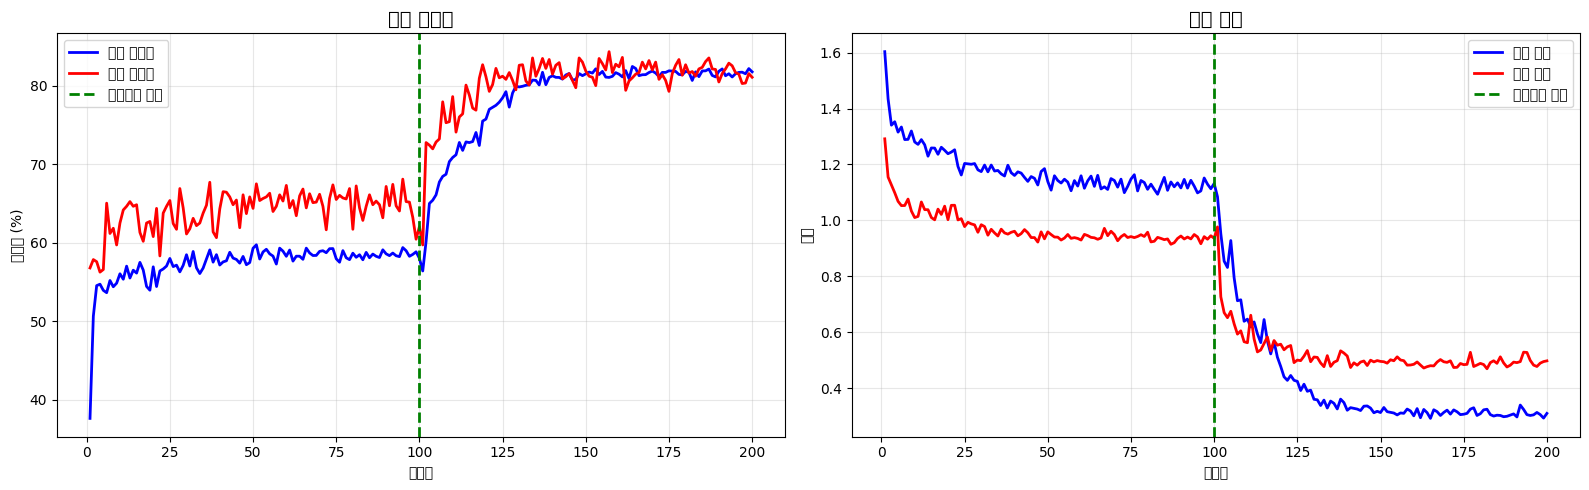


최종 학습 결과
최종 학습 정확도: 81.78%
최종 검증 정확도: 81.09%
최고 검증 정확도: 84.35%


In [17]:
# 학습 히스토리 통합 및 시각화
train_loss = history_stage1['train_loss'] + history_stage2['train_loss']
train_acc = history_stage1['train_acc'] + history_stage2['train_acc']
val_loss = history_stage1['val_loss'] + history_stage2['val_loss']
val_acc = history_stage1['val_acc'] + history_stage2['val_acc']

epochs_range = range(1, len(train_loss) + 1)
stage1_end = len(history_stage1['train_loss'])

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 정확도
axes[0].plot(epochs_range, train_acc, 'b-', label='학습 정확도', linewidth=2)
axes[0].plot(epochs_range, val_acc, 'r-', label='검증 정확도', linewidth=2)
axes[0].axvline(x=stage1_end, color='green', linestyle='--', label='미세조정 시작', linewidth=2)
axes[0].set_title('모델 정확도', fontsize=14, fontweight='bold')
axes[0].set_xlabel('에포크')
axes[0].set_ylabel('정확도 (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 손실
axes[1].plot(epochs_range, train_loss, 'b-', label='학습 손실', linewidth=2)
axes[1].plot(epochs_range, val_loss, 'r-', label='검증 손실', linewidth=2)
axes[1].axvline(x=stage1_end, color='green', linestyle='--', label='미세조정 시작', linewidth=2)
axes[1].set_title('모델 손실', fontsize=14, fontweight='bold')
axes[1].set_xlabel('에포크')
axes[1].set_ylabel('손실')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("최종 학습 결과")
print("="*60)
print(f"최종 학습 정확도: {train_acc[-1]:.2f}%")
print(f"최종 검증 정확도: {val_acc[-1]:.2f}%")
print(f"최고 검증 정확도: {best_val_acc:.2f}%")
print("="*60)

## 11. 테스트 데이터 평가

In [18]:
# 최고 성능 모델 로드
model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'mobilenet_skin_disease_finetuned.pth')))
model.eval()

# 테스트 데이터 평가
all_preds = []
all_labels = []
all_probs = []

print("테스트 데이터 평가 중...")
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# 정확도 계산
test_accuracy = accuracy_score(all_labels, all_preds)

print("\n" + "="*60)
print("테스트 데이터 최종 성능")
print("="*60)
print(f"테스트 정확도: {test_accuracy*100:.2f}%")
print("="*60)

테스트 데이터 평가 중...


100%|██████████| 47/47 [00:12<00:00,  3.72it/s]


테스트 데이터 최종 성능
테스트 정확도: 83.57%


In [19]:
# 분류 리포트
print("\n" + "="*60)
print("상세 분류 리포트")
print("="*60)
target_names = [f"{idx_to_class[i]} ({class_names[idx_to_class[i]]})" for i in range(NUM_CLASSES)]
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))


상세 분류 리포트
               precision    recall  f1-score   support

akiec (광선각화증)     0.6964    0.7959    0.7429        49
  bcc (기저세포암)     0.7412    0.8182    0.7778        77
  bkl (양성각화증)     0.6183    0.6970    0.6553       165
   df (피부섬유종)     0.7333    0.6471    0.6875        17
    mel (흑색종)     0.5851    0.6587    0.6197       167
   nv (멜라닌모반)     0.9454    0.8956    0.9199      1006
  vasc (혈관병변)     0.8500    0.7727    0.8095        22

     accuracy                         0.8357      1503
    macro avg     0.7385    0.7550    0.7446      1503
 weighted avg     0.8471    0.8357    0.8402      1503



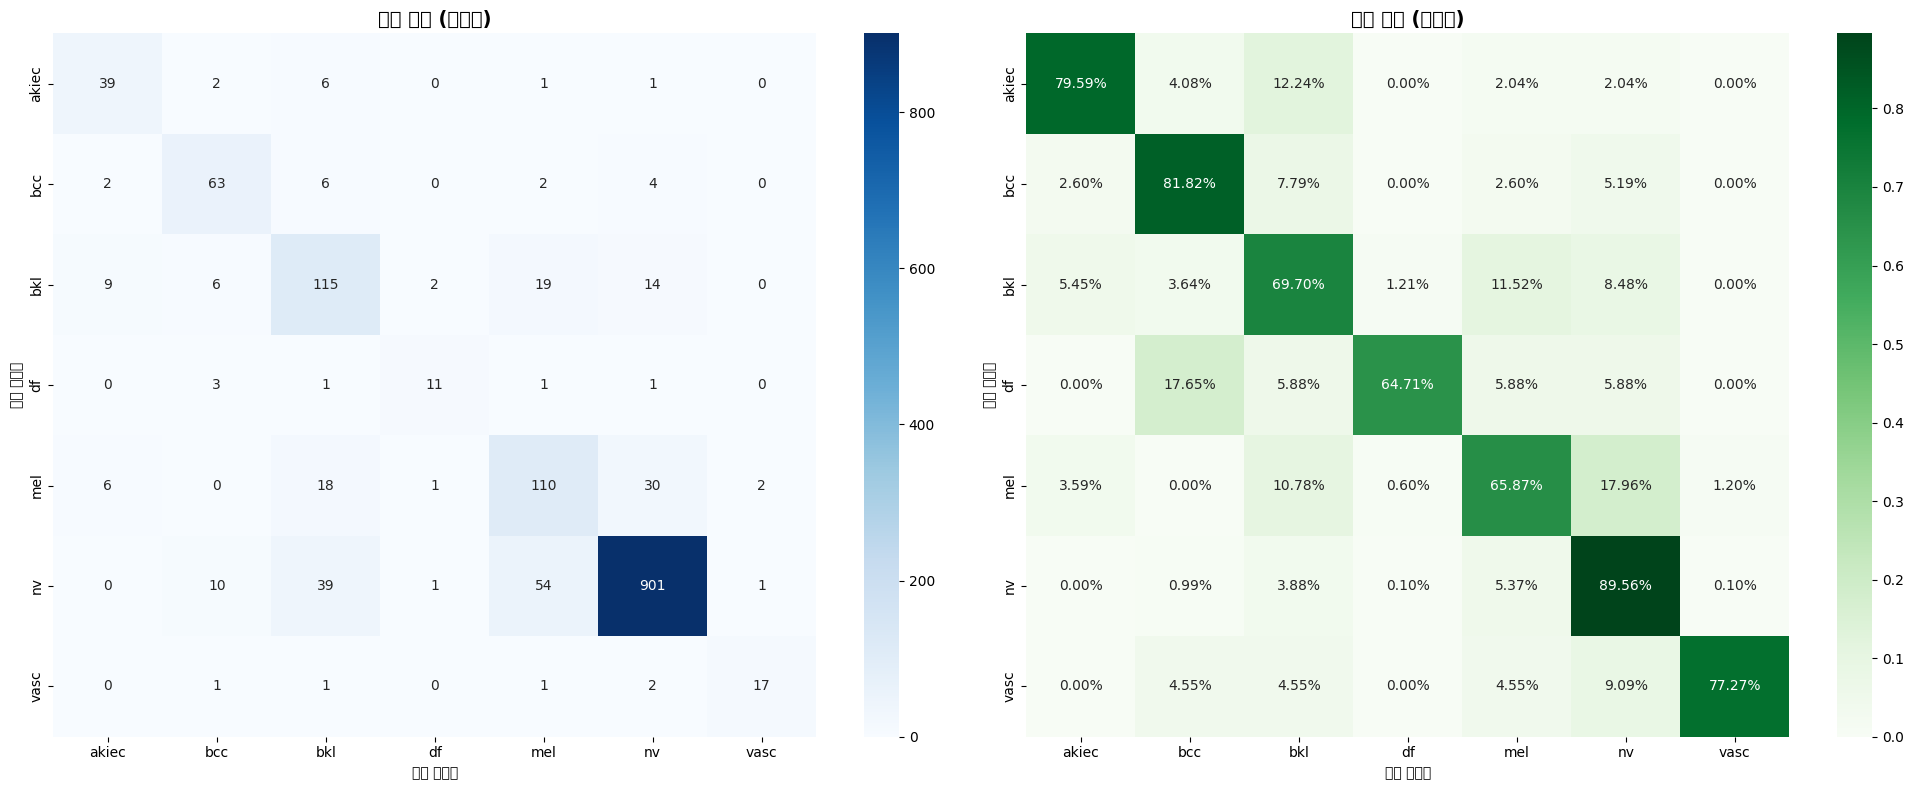

In [20]:
# 혼동 행렬 시각화
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 절대값 혼동 행렬
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=[idx_to_class[i] for i in range(NUM_CLASSES)],
            yticklabels=[idx_to_class[i] for i in range(NUM_CLASSES)])
axes[0].set_title('혼동 행렬 (절대값)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('예측 클래스')
axes[0].set_ylabel('실제 클래스')

# 정규화된 혼동 행렬
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=[idx_to_class[i] for i in range(NUM_CLASSES)],
            yticklabels=[idx_to_class[i] for i in range(NUM_CLASSES)])
axes[1].set_title('혼동 행렬 (정규화)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('예측 클래스')
axes[1].set_ylabel('실제 클래스')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

## 12. 모델 저장 (ONNX 변환 - 모바일용)

In [25]:
# PyTorch 모델을 TFLite로 변환 (모바일/Flutter용)
print("=" * 60)
print("TFLite 모델 변환 시작")
print("=" * 60)

# MODEL_DIR 정의 (이전 셀에서 정의되지 않은 경우)
try:
    MODEL_DIR
except NameError:
    MODEL_DIR = './models'
    print(f"⚠️ MODEL_DIR이 정의되지 않아 기본값으로 설정: {MODEL_DIR}")
    os.makedirs(MODEL_DIR, exist_ok=True)

# NUM_CLASSES 정의 (이전 셀에서 정의되지 않은 경우)
try:
    NUM_CLASSES
except NameError:
    NUM_CLASSES = 7  # 피부 질환 클래스 수
    print(f"⚠️ NUM_CLASSES가 정의되지 않아 기본값으로 설정: {NUM_CLASSES}")

# 저장된 모델 불러오기
print("\n[0/3] 학습된 모델 불러오기...")
model_path = os.path.join(MODEL_DIR, 'mobilenet_skin_disease_finetuned.pth')

if not os.path.exists(model_path):
    print(f"⚠️ 모델 파일을 찾을 수 없습니다: {model_path}")
    print("   먼저 모델 학습을 완료하세요.")
else:
    # 모델 아키텍처 재정의 (학습 시와 동일하게)
    import torchvision.models as models
    import torch.nn as nn
    model = models.mobilenet_v2(pretrained=False)
    
    # 학습 시 사용한 정확한 구조로 재정의
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.3),
        nn.Linear(256, NUM_CLASSES)
    )
    
    # 저장된 가중치 로드
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    model_size = os.path.getsize(model_path) / (1024*1024)
    print(f"✓ 모델 로드 완료: {model_path}")
    print(f"  모델 크기: {model_size:.2f} MB")
    print(f"  클래스 수: {NUM_CLASSES}")
    
    # IMG_SIZE 정의 (이전 셀에서 정의되지 않은 경우)
    try:
        IMG_SIZE
    except NameError:
        IMG_SIZE = 224
        print(f"⚠️ IMG_SIZE가 정의되지 않아 기본값으로 설정: {IMG_SIZE}")
    
    # 더미 입력 생성
    dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
    
    # 1단계: PyTorch → ONNX 변환
    onnx_path = os.path.join(MODEL_DIR, 'skin_disease_mobilenet.onnx')
    onnx_success = False
    
    try:
        print("\n[1/3] PyTorch → ONNX 변환 중...")
        torch.onnx.export(
            model,
            dummy_input,
            onnx_path,
            export_params=True,
            opset_version=11,
            do_constant_folding=True,
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
        )
        
        if os.path.exists(onnx_path):
            onnx_size = os.path.getsize(onnx_path) / (1024*1024)
            print(f"✓ ONNX 모델 저장 완료: {onnx_path}")
            print(f"  모델 크기: {onnx_size:.2f} MB")
            onnx_success = True
        else:
            print("⚠️ ONNX 파일이 생성되지 않았습니다.")
            
    except Exception as e:
        print(f"⚠️ ONNX 변환 실패: {str(e)}")
        print("   PyTorch 모델(.pth)은 정상적으로 저장되었습니다.")
    
    # 2단계: ONNX → TensorFlow → TFLite 변환
    tflite_success = False
    
    if onnx_success:
        try:
            print("\n[2/3] ONNX → TensorFlow 변환 중 (onnx-tf 사용)...")
            # 필요한 패키지 확인 및 설치
            import subprocess
            import sys
            
            # onnx-tf 시도 (호환성 문제가 있을 수 있음)
            onnx_tf_success = False
            try:
                print("  [방법 1] onnx-tf 사용 시도...")
                # 기존 패키지 제거
                try:
                    subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "onnx", "onnx-tf", "-y"], 
                                        stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                except:
                    pass
                
                # 호환되는 버전 설치 (여러 버전 시도)
                onnx_versions = ["1.9.0", "1.8.1", "1.7.0"]
                onnx_installed = False
                for version in onnx_versions:
                    try:
                        print(f"    onnx {version} 설치 시도...")
                        subprocess.check_call([sys.executable, "-m", "pip", "install", f"onnx=={version}", "--no-deps"], 
                                            stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                        print(f"    ✓ onnx {version} 설치 완료")
                        onnx_installed = True
                        break
                    except:
                        continue
                
                if not onnx_installed:
                    raise Exception("호환되는 onnx 버전 설치 실패")
                
                # onnx-tf 설치
                print("    onnx-tf 설치 중...")
                subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx-tf"], 
                                    stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                print("    ✓ onnx-tf 설치 완료")
                
                # 패키지 import 테스트
                import onnx
                from onnx_tf.backend import prepare
                import tensorflow as tf
                
                # mapping 테스트
                try:
                    from onnx import mapping
                    onnx_tf_success = True
                    print("  ✓ onnx-tf 사용 가능!")
                except ImportError:
                    raise ImportError("onnx mapping import 실패")
                    
            except Exception as e:
                print(f"  ⚠️ onnx-tf 사용 실패: {str(e)}")
                print("  [방법 2] onnx2tf로 폴백 시도...")
                
                # onnx2tf 설치
                try:
                    subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "onnx", "onnx-tf", "-y"], 
                                        stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                except:
                    pass
                
                try:
                    print("    최신 onnx 설치 중...")
                    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"], 
                                        stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                except:
                    pass
                
                try:
                    print("    onnx2tf 설치 중...")
                    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx2tf"], 
                                        stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                    print("    ✓ onnx2tf 설치 완료")
                except:
                    raise Exception("onnx2tf 설치 실패")
                
                import onnx2tf
                import tensorflow as tf
                onnx_tf_success = False  # onnx2tf 사용
            
            # 변환 방식 결정
            if onnx_tf_success:
                import onnx
                from onnx_tf.backend import prepare
                import tensorflow as tf
                use_onnx2tf = False
            else:
                import onnx2tf
                import tensorflow as tf
                use_onnx2tf = True
            
            # 변환 플로우 표시
            print("\n  변환 플로우:")
            print("  ONNX 파일 (.onnx)")
            print("    ↓")
            print("  [onnx-tf 사용]")
            print("    ↓")
            print("  TensorFlow 모델 (SavedModel)")
            print("    ↓")
            print("  [TensorFlow Lite Converter 사용]")
            print("    ↓")
            print("  TensorFlow Lite 파일 (.tflite) ✅")
            print()
            
            # 1단계: ONNX 모델 로드
            print("  [1/2] ONNX 모델 로드 중...")
            import onnx
            onnx_model = onnx.load(onnx_path)
            print(f"    ✓ ONNX 모델 로드 완료: {os.path.basename(onnx_path)}")
            
            # 2단계: ONNX → TensorFlow (SavedModel) 변환
            tf_model_path = os.path.join(MODEL_DIR, 'tf_model')
            import shutil
            if os.path.exists(tf_model_path):
                shutil.rmtree(tf_model_path)
            
            if use_onnx2tf:
                print("  [2/2] ONNX → TensorFlow 변환 중 (onnx2tf 사용)...")
                onnx2tf.convert(
                    input_onnx_file_path=onnx_path,
                    output_folder_path=tf_model_path,
                    copy_onnx_input_output_names_to_tflite=True,
                )
            else:
                print("  [2/2] ONNX → TensorFlow 변환 중 (onnx-tf 사용)...")
                from onnx_tf.backend import prepare
                tf_rep = prepare(onnx_model)
                tf_rep.export_graph(tf_model_path)
            
            print("    ✓ TensorFlow SavedModel 변환 완료")
            
            # 3단계: TensorFlow → TFLite 변환
            print("\n[3/3] TensorFlow → TFLite 변환 중 (TensorFlow Lite Converter 사용)...")
            converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            
            tflite_model = converter.convert()
            
            tflite_path = os.path.join(MODEL_DIR, 'skin_disease_mobilenet.tflite')
            with open(tflite_path, 'wb') as f:
                f.write(tflite_model)
            
            tflite_size = os.path.getsize(tflite_path) / (1024*1024)
            print(f"✓ TFLite 모델 저장 완료: {tflite_path}")
            print(f"  모델 크기: {tflite_size:.2f} MB")
            print("  이 모델은 Flutter/TensorFlow Lite에서 사용 가능합니다.")
            tflite_success = True
            
            if os.path.exists(tf_model_path):
                shutil.rmtree(tf_model_path)
                print("  임시 디렉토리 정리 완료")
                
        except Exception as e:
            print(f"\n⚠️ TFLite 변환 실패: {str(e)}")
            print("\n해결 방법:")
            print("   1. Jupyter 커널 재시작 후 다시 시도")
            print("   2. 또는 새 노트북 셀에서 실행:")
            print("      !pip install onnx onnx-tf tensorflow")
            print("\n   ONNX 모델은 저장되었으며 Flutter에서 사용 가능합니다.")
    
    # TorchScript 모델 저장 (백업용)
    try:
        traced_model = torch.jit.trace(model, dummy_input)
        traced_path = os.path.join(MODEL_DIR, 'traced_model.pt')
        traced_model.save(traced_path)
        traced_size = os.path.getsize(traced_path) / (1024*1024)
        print(f"\n✓ TorchScript 모델 저장 완료: {traced_path}")
        print(f"  모델 크기: {traced_size:.2f} MB")
    except Exception as e:
        print(f"\n⚠️ TorchScript 모델 저장 실패: {str(e)}")
    
    # 최종 결과 요약
    print("\n" + "=" * 60)
    print("변환 결과 요약")
    print("=" * 60)
    print(f"✓ PyTorch 모델: mobilenet_skin_disease_finetuned.pth (항상 저장됨)")
    if onnx_success:
        print(f"✓ ONNX 모델: skin_disease_mobilenet.onnx")
    if tflite_success:
        print(f"✓ TFLite 모델: skin_disease_mobilenet.tflite (Flutter용)")
        print("\n변환 경로: PyTorch → ONNX → TensorFlow → TFLite")
    else:
        print("⚠️ TFLite 모델: 변환 실패 (ONNX 모델 사용 가능)")
        print("\n대안: ONNX 모델을 Flutter에서 사용하세요")
        print("   - pubspec.yaml에 onnxruntime 패키지 추가")
        print("   - ONNX 모델도 Flutter에서 완벽하게 작동합니다")
    print("=" * 60)
    
    # 클래스 레이블 저장
    import json
    
    # idx_to_class와 class_names 정의 (이전 셀에서 정의되지 않은 경우)
    try:
        idx_to_class
        class_names
    except NameError:
        # 기본 클래스 정보 설정
        idx_to_class = {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
        class_names = {
            'akiec': 'Actinic keratoses',
            'bcc': 'Basal cell carcinoma',
            'bkl': 'Benign keratosis-like lesions',
            'df': 'Dermatofibroma',
            'mel': 'Melanoma',
            'nv': 'Melanocytic nevi',
            'vasc': 'Vascular lesions'
        }
        print(f"⚠️ 클래스 정보가 정의되지 않아 기본값으로 설정")
    
    labels_dict = {
        'classes': {idx: {'code': idx_to_class[idx], 'name': class_names[idx_to_class[idx]]} 
                    for idx in range(NUM_CLASSES)}
    }
    
    labels_path = os.path.join(MODEL_DIR, 'labels.json')
    with open(labels_path, 'w', encoding='utf-8') as f:
        json.dump(labels_dict, f, ensure_ascii=False, indent=2)
    
    print(f"\n✓ 레이블 파일 저장 완료: {labels_path}")
    
    print("\n" + "="*60)
    print("저장된 파일 목록:")
    print("="*60)
    print(f"✓ PyTorch 모델: mobilenet_skin_disease_finetuned.pth")
    if os.path.exists(os.path.join(MODEL_DIR, 'skin_disease_mobilenet.onnx')):
        print(f"✓ ONNX 모델: skin_disease_mobilenet.onnx")
    if os.path.exists(os.path.join(MODEL_DIR, 'skin_disease_mobilenet.tflite')):
        print(f"✓ TFLite 모델: skin_disease_mobilenet.tflite (Flutter용)")
    if os.path.exists(os.path.join(MODEL_DIR, 'traced_model.pt')):
        print(f"✓ TorchScript 모델: traced_model.pt (백업)")
    print(f"✓ 레이블 파일: labels.json")
    print("="*60)

TFLite 모델 변환 시작

[0/3] 학습된 모델 불러오기...
✓ 모델 로드 완료: ./models\mobilenet_skin_disease_finetuned.pth
  모델 크기: 9.99 MB
  클래스 수: 7

[1/3] PyTorch → ONNX 변환 중...
✓ ONNX 모델 저장 완료: ./models\skin_disease_mobilenet.onnx
  모델 크기: 9.72 MB

[2/3] ONNX → TensorFlow 변환 중 (onnx-tf 사용)...
  [방법 1] onnx-tf 사용 시도...
    onnx 1.9.0 설치 시도...
    onnx 1.8.1 설치 시도...
    onnx 1.7.0 설치 시도...
  ⚠️ onnx-tf 사용 실패: 호환되는 onnx 버전 설치 실패
  [방법 2] onnx2tf로 폴백 시도...
    최신 onnx 설치 중...
    onnx2tf 설치 중...
    ✓ onnx2tf 설치 완료

⚠️ TFLite 변환 실패: No module named 'onnx_graphsurgeon'

해결 방법:
   1. Jupyter 커널 재시작 후 다시 시도
   2. 또는 새 노트북 셀에서 실행:
      !pip install onnx onnx-tf tensorflow

   ONNX 모델은 저장되었으며 Flutter에서 사용 가능합니다.

✓ TorchScript 모델 저장 완료: ./models\traced_model.pt
  모델 크기: 10.32 MB

변환 결과 요약
✓ PyTorch 모델: mobilenet_skin_disease_finetuned.pth (항상 저장됨)
✓ ONNX 모델: skin_disease_mobilenet.onnx
⚠️ TFLite 모델: 변환 실패 (ONNX 모델 사용 가능)

대안: ONNX 모델을 Flutter에서 사용하세요
   - pubspec.yaml에 onnxruntime 패키지 추가
   - ONNX 모델도 Flutter에서 완벽하

## 🎉 학습 완료!

### 저장된 파일:
- `mobilenet_skin_disease_best_stage1.pth` - 1단계 최고 성능 모델
- `mobilenet_skin_disease_finetuned.pth` - 2단계 미세조정 모델
- `skin_disease_mobilenet.onnx` - ONNX 형식 (모바일/Flutter용)
- `labels.json` - 클래스 레이블 정보
- `training_history.png` - 학습 히스토리 그래프
- `confusion_matrix.png` - 혼동 행렬

### PyTorch 모델 사용 예시:
```python
# 모델 로드
model = models.mobilenet_v2()
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(1280, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.3),
    nn.Linear(256, 7)
)
model.load_state_dict(torch.load('mobilenet_skin_disease_finetuned.pth'))
model.eval()

# 예측
image = Image.open('test_image.jpg')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image_tensor = transform(image).unsqueeze(0)
with torch.no_grad():
    output = model(image_tensor)
    probs = torch.softmax(output, dim=1)
    pred_class = output.argmax(1).item()
```

### 주의사항:
- 이 모델은 의료 진단 보조 도구이며, 전문의의 진단을 대체할 수 없습니다.
- 실제 의료 서비스로 사용하기 전에 임상 검증이 필요합니다.